In [ ]:
"""

Script to compute the true grid cell area of a polar stereographic grid

"""

In [1]:
from pyproj import CRS, Transformer, Geod
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm

In [2]:
inputpath_NEMO_interim = '/data/cburgard/PREPARE_FORCING/PREPARE_CAVITY_MASKS/interim/'


In [3]:
# define the projections
crs_ps = CRS.from_epsg(3031)  
crs_ll = CRS.from_epsg(4326)
to_ll = Transformer.from_crs(crs_ps, crs_ll, always_xy=True)
geod = Geod(ellps='WGS84') 

In [4]:
grid_cell_area = xr.open_dataset(inputpath_NEMO_interim + 'ISMIP6_grid_AIS_2000m.nc')

In [5]:
xx = grid_cell_area.x
yy = grid_cell_area.y
dx = (xx[1] - xx[0]).values
dy = (yy[1] - yy[0]).values

meshx,meshy = np.meshgrid(xx,yy)

In [6]:
# corners of one cell (x,y are cell center; dx,dy are spacing)
xs = np.array([meshx-dx/2, meshx+dx/2, meshx+dx/2, meshx-dx/2])
ys = np.array([meshy-dy/2, meshy-dy/2, meshy+dy/2, meshy+dy/2])
lons, lats = to_ll.transform(xs, ys)

In [17]:
# compute area
A_true = np.zeros((lons.shape[1],lats.shape[2]))
for ii in tqdm(range(lons.shape[1])):
    for jj in range(lons.shape[2]):
        area, _ = geod.polygon_area_perimeter(lons[:,ii,jj], lats[:,ii,jj])
        A_true[ii,jj] = abs(area)  # m^2

  0%|          | 0/3041 [00:00<?, ?it/s]

In [23]:
area_da = xr.DataArray(data=A_true, dims=['y','x']).assign_coords({'y': yy, 'x': xx})
area_da.rename('true_grid_cell_area').to_netcdf(inputpath_NEMO_interim + 'ISMIP6_grid_area_AIS_2000m.nc')

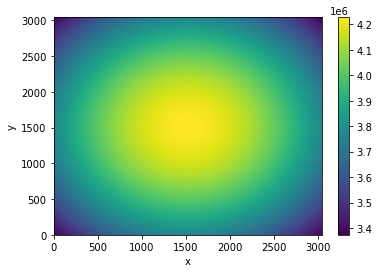

In [22]:
area_da.plot()